# **[데이콘] 소설 작가 분류 AI 경진대회**

##1. 라이브러리

In [ ]:
pip install nltk

In [ ]:
!pip install catboost
from catboost import Pool, CatBoostClassifier

     |████████████████████████████████| 66.3MB 44kB/s 


In [ ]:
#필요 라이브러리 호출
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.metrics import confusion_matrix
color = sns.color_palette()

%matplotlib inline

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [ ]:
train= pd.read_csv("/content/drive/MyDrive/novel/novel/train_3.csv")
test= pd.read_csv("/content/drive/MyDrive/novel/novel/test_3.csv")
print("Number of rows in train dataset : ",train.shape[0])
print("Number of rows in test dataset : ",test.shape[0])

Number of rows in train dataset :  54879
Number of rows in test dataset :  19617


##2. 데이터 탐색

In [ ]:
#작가 별로 그룹화
grouped_df = train.groupby('author')
for number, group in grouped_df:
    print("Author number : ", number)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author number :  0
'You were not here last Sunday night,' he said.
I had scant luggage to take with me to London, for little of the little I possessed was adapted to my new station. But I began packing that same afternoon, and wildly packed up things that I knew I should want next morning, in a fiction that there was not a moment to be lost.
‘Why, the fact is,’ returned odin, ‘Mr. odin had so completely hemmed him in, and was always ready with so many new points if an old one failed, that he could not escape from us. A most remarkable circumstance is, that I really don’t think he grasped this sum even so much for the gratification of his avarice, which was inordinate, as in the hatred he felt for odin. He said so to me, plainly. He said he would even have spent as much, to baulk or injure odin.’
Dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and I had made up my mind that it should not be there. If there must be s

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


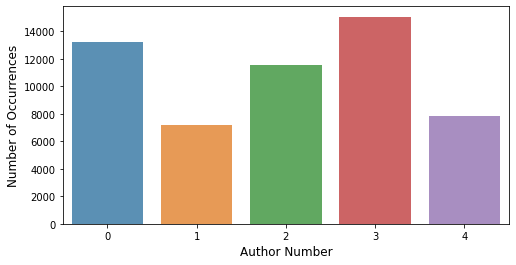

In [ ]:
cnt_srs = train['author'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Number', fontsize=12)
plt.show()

text에 따른 다양한 feature 생성

In [ ]:
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))

train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))

train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))

train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

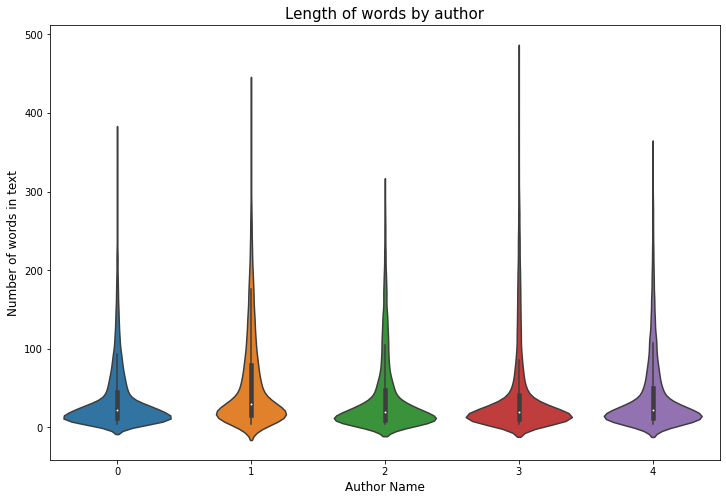

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train)
plt.xlabel('Author Number', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Length of words by author", fontsize=15)
plt.show()

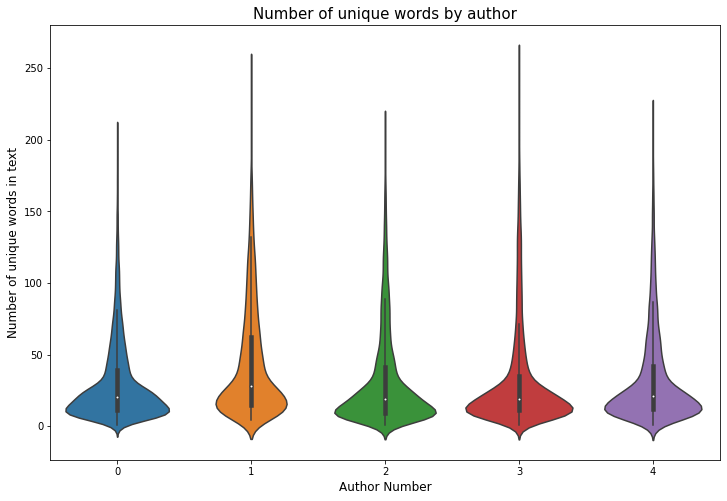

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_unique_words', data=train)
plt.xlabel('Author Number', fontsize=12)
plt.ylabel('Number of unique words in text', fontsize=12)
plt.title("Number of unique words by author", fontsize=15)
plt.show()

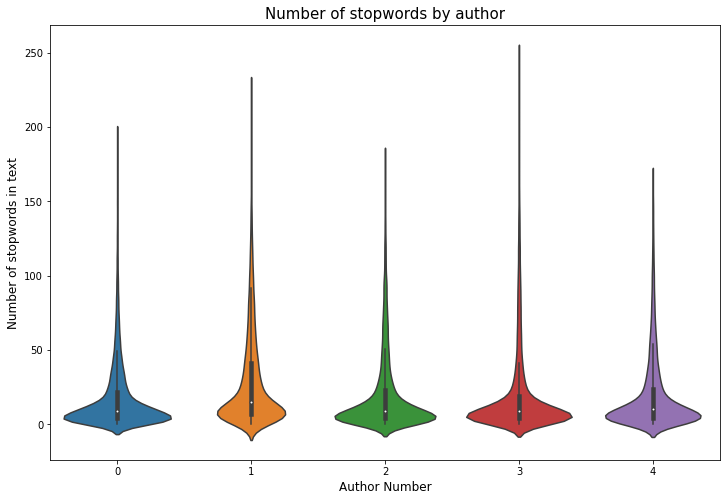

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_stopwords', data=train)
plt.xlabel('Author Number', fontsize=12)
plt.ylabel('Number of stopwords in text', fontsize=12)
plt.title("Number of stopwords by author", fontsize=15)
plt.show()

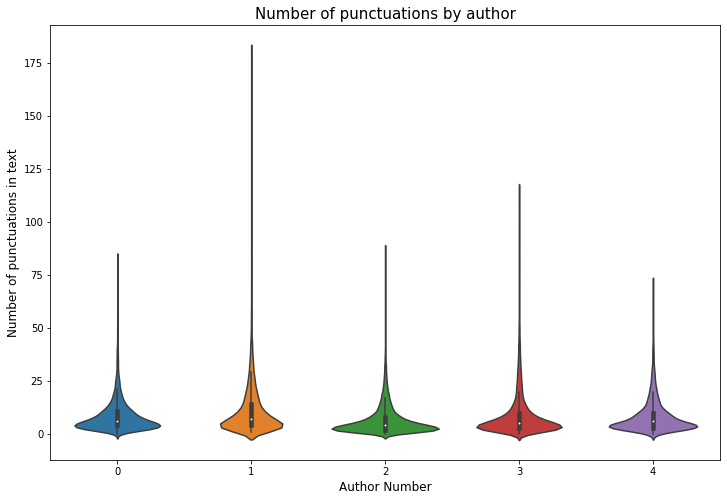

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train)
plt.xlabel('Author Number', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

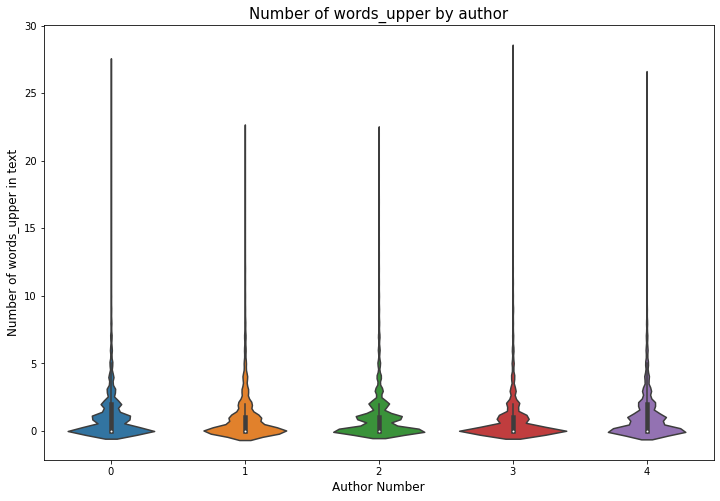

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words_upper', data=train)
plt.xlabel('Author Number', fontsize=12)
plt.ylabel('Number of words_upper in text', fontsize=12)
plt.title("Number of words_upper by author", fontsize=15)
plt.show()

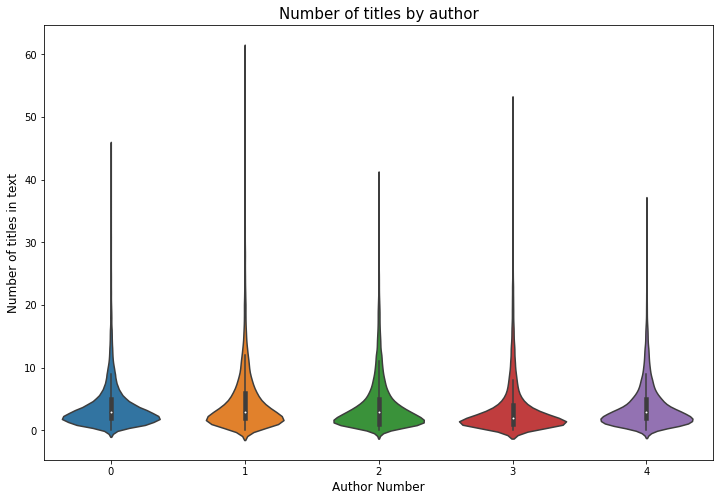

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words_title', data=train)
plt.xlabel('Author Number', fontsize=12)
plt.ylabel('Number of titles in text', fontsize=12)
plt.title("Number of titles by author", fontsize=15)
plt.show()

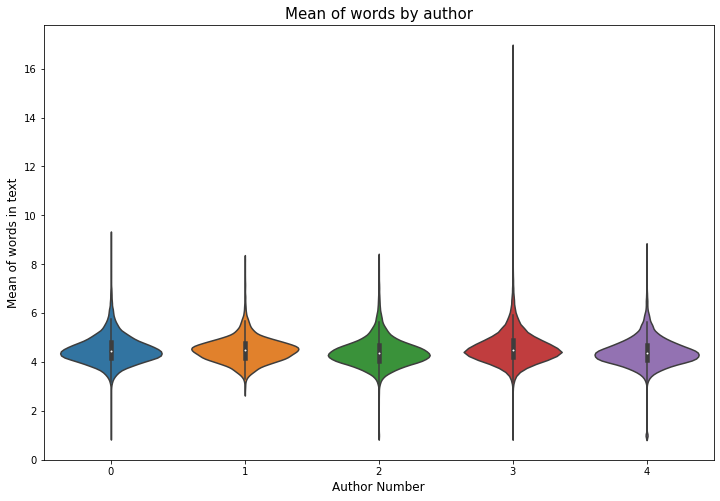

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='mean_word_len', data=train)
plt.xlabel('Author Number', fontsize=12)
plt.ylabel('Mean of words in text', fontsize=12)
plt.title("Mean of words by author", fontsize=15)
plt.show()

In [ ]:
train['num_punctuations'].loc[train['num_punctuations']>10] = 10 #최종제출 파일 코드에 뺀다는걸 깜빡했습니다. 처리를 안하는게 결과가 더 좋습니다.

일반적으로 제거하는 불용어나 부호도 작가마다 유의미한 차이를 보인다고 판단하여 별다른 처리를 하지 않았습니다.

##3. TF-IDF,특이값 분해 feature 생성

LSA와 관련된 링크입니다. 
https://wikidocs.net/24949

In [ ]:
train_y=train['author']
train_X = train.drop(['text','author'], axis=1)
test_X = test.drop(['text'], axis=1)

In [ ]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

Feature 생성에 이용한 모델은 Multinomial Naive Bayes와 LGBM입니다. MNB의 경우 가장 빠른 모델이고 LGBM은 시간은 좀 걸리지만 정확도가 매우 뛰어납니다.계산시간 때문에 최적화를 하지 않은 상태인데  gpu 사용과 함께 모델 최적화를 진행하면 더 좋은 결과값을 낼 수 있을 겁니다.

In [ ]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [ ]:
import lightgbm as lgb
def runLGB(train_X,train_y,test_X,test_y,test_X2):
  
  params={}
  params['learning_rate']=0.1 
  params['boosting_type']='gbdt' #GradientBoostingDecisionTree
  params['objective']='multiclass' #Multi-class target feature
  params['metric']='multi_logloss' #metric for multi-class
  params['max_depth']=5
  params['num_class']=5
  params['num_leaves']=31
  
 
  d_train=lgb.Dataset(train_X,label=train_y)
  d_val=lgb.Dataset(test_X,label=test_y)
  model=lgb.train(params,d_train,3000,valid_sets=d_val,early_stopping_rounds=50,verbose_eval=50)
  pred_test_y=model.predict(test_X)
  pred_test_y2=model.predict(test_X2)
  return pred_test_y,pred_test_y2,model
  

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  1.206228258630992


In [ ]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train = pd.concat([train, train_svd], axis=1)
test= pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test+=pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# stacking #
train["nb_cvec_0"] = pred_train[:,0]
train["nb_cvec_1"] = pred_train[:,1]
train["nb_cvec_2"] = pred_train[:,2]
train["nb_cvec_3"] = pred_train[:,3]
train["nb_cvec_4"] = pred_train[:,4]
test["nb_cvec_0"] = pred_full_test[:,0]
test["nb_cvec_1"] = pred_full_test[:,1]
test["nb_cvec_2"] = pred_full_test[:,2]
test["nb_cvec_3"] = pred_full_test[:,3]
test["nb_cvec_4"] = pred_full_test[:,4]

Mean cv score :  1.1789477530668817


In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    dev_X=dev_X.astype('float32')
    dev_y=dev_y.astype('float32')
    val_X=val_X.astype('float32')
    val_y=val_y.astype('float32')
    test_tfidf=test_tfidf.astype('float32')
    pred_val_y, pred_test_y, model = runLGB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test+=pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# stacking #
train["lgb_cvec_0"] = pred_train[:,0]
train["lgb_cvec_1"] = pred_train[:,1]
train["lgb_cvec_2"] = pred_train[:,2]
train["lgb_cvec_3"] = pred_train[:,3]
train["lgb_cvec_4"] = pred_train[:,4]
test["lgb_cvec_0"] = pred_full_test[:,0]
test["lgb_cvec_1"] = pred_full_test[:,1]
test["lgb_cvec_2"] = pred_full_test[:,2]
test["lgb_cvec_3"] = pred_full_test[:,3]
test["lgb_cvec_4"] = pred_full_test[:,4]

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 1.26238
[100]	valid_0's multi_logloss: 1.17696
[150]	valid_0's multi_logloss: 1.12573
[200]	valid_0's multi_logloss: 1.08889
[250]	valid_0's multi_logloss: 1.06013
[300]	valid_0's multi_logloss: 1.03653
[350]	valid_0's multi_logloss: 1.01689
[400]	valid_0's multi_logloss: 1.0002
[450]	valid_0's multi_logloss: 0.98585
[500]	valid_0's multi_logloss: 0.972757
[550]	valid_0's multi_logloss: 0.96136
[600]	valid_0's multi_logloss: 0.950892
[650]	valid_0's multi_logloss: 0.94162
[700]	valid_0's multi_logloss: 0.932687
[750]	valid_0's multi_logloss: 0.924677
[800]	valid_0's multi_logloss: 0.917306
[850]	valid_0's multi_logloss: 0.910379
[900]	valid_0's multi_logloss: 0.90423
[950]	valid_0's multi_logloss: 0.898378
[1000]	valid_0's multi_logloss: 0.892829
[1050]	valid_0's multi_logloss: 0.88774
[1100]	valid_0's multi_logloss: 0.883006
[1150]	valid_0's multi_logloss: 0.878313
[1200]	valid_0's multi_loglos

In [ ]:
tfidf_vec = CountVectorizer(ngram_range=(1,6), analyzer='char')
tfidf_vec.fit(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# stacking #
train["nb_cvec_char_0"] = pred_train[:,0]
train["nb_cvec_char_1"] = pred_train[:,1]
train["nb_cvec_char_2"] = pred_train[:,2]
train["nb_cvec_char_3"] = pred_train[:,3]
train["nb_cvec_char_4"] = pred_train[:,4]
test["nb_cvec_char_0"] = pred_full_test[:,0]
test["nb_cvec_char_1"] = pred_full_test[:,1]
test["nb_cvec_char_2"] = pred_full_test[:,2]
test["nb_cvec_char_3"] = pred_full_test[:,3]
test["nb_cvec_char_4"] = pred_full_test[:,4]

Mean cv score :  4.985579793542322


In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    dev_X=dev_X.astype('float32')
    dev_y=dev_y.astype('float32')
    val_X=val_X.astype('float32')
    val_y=val_y.astype('float32')
    test_tfidf=test_tfidf.astype('float32')
    pred_val_y, pred_test_y, model = runLGB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test+=pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# stacking #
train["lgb_cvec_char_0"] = pred_train[:,0]
train["lgb_cvec_char_1"] = pred_train[:,1]
train["lgb_cvec_char_2"] = pred_train[:,2]
train["lgb_cvec_char_3"] = pred_train[:,3]
train["lgb_cvec_char_4"] = pred_train[:,4]
test["lgb_cvec_char_0"] = pred_full_test[:,0]
test["lgb_cvec_char_1"] = pred_full_test[:,1]
test["lgb_cvec_char_2"] = pred_full_test[:,2]
test["lgb_cvec_char_3"] = pred_full_test[:,3]
test["lgb_cvec_char_4"] = pred_full_test[:,4]

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# stacking #
train["nb_tfidf_char_0"] = pred_train[:,0]
train["nb_tfidf_char_1"] = pred_train[:,1]
train["nb_tfidf_char_2"] = pred_train[:,2]
train["nb_tfidf_char_3"] = pred_train[:,3]
train["nb_tfidf_char_4"] = pred_train[:,4]
test["nb_tfidf_char_0"] = pred_full_test[:,0]
test["nb_tfidf_char_1"] = pred_full_test[:,1]
test["nb_tfidf_char_2"] = pred_full_test[:,2]
test["nb_tfidf_char_3"] = pred_full_test[:,3]
test["nb_tfidf_char_4"] = pred_full_test[:,4]

Mean cv score :  1.0897097635752746


In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    dev_X=dev_X.astype('float32')
    dev_y=dev_y.astype('float32')
    val_X=val_X.astype('float32')
    val_y=val_y.astype('float32')
    test_tfidf=test_tfidf.astype('float32')
    pred_val_y, pred_test_y, model = runLGB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test+=pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# stacking #
train["lgb_tfidf_char_0"] = pred_train[:,0]
train["lgb_tfidf_char_1"] = pred_train[:,1]
train["lgb_tfidf_char_2"] = pred_train[:,2]
train["lgb_tfidf_char_3"] = pred_train[:,3]
train["lgb_tfidf_char_4"] = pred_train[:,4]
test["lgb_tfidf_char_0"] = pred_full_test[:,0]
test["lgb_tfidf_char_1"] = pred_full_test[:,1]
test["lgb_tfidf_char_2"] = pred_full_test[:,2]
test["lgb_tfidf_char_3"] = pred_full_test[:,3]
test["lgb_tfidf_char_4"] = pred_full_test[:,4]

LSA 특이값 분해

In [ ]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train= pd.concat([train, train_svd], axis=1)
test= pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
train_X = train.drop(['text','author'], axis=1)
test_X = test.drop(['text'], axis=1)

##4.모형 학습

AutoML로 분류모형 성능 비교했을 때 Catboost가 가장 결과가 좋아서 최종 모형으로 사용하였습니다.

In [ ]:
def runCat(train_X,train_y,test_X,test_y,test_X2):
  cat_features=[0]
  train_dataset = Pool(data=train_X,
                     label=train_y,
                     cat_features=cat_features)

  eval_dataset = Pool(data=test_X,
                    label=test_y,
                    cat_features=cat_features)
  model = CatBoostClassifier(iterations=22000,
                           learning_rate=0.01,
                           depth=4,
                           loss_function='MultiClass',
                           eval_metric='MultiClass',
                           task_type="GPU",#GPU이용시 계산이 빨라 earlystop 굳이 안넣어도 괜찮았습니다.
                           
                           
                           verbose=50)
  model.fit(train_dataset,eval_set=eval_dataset)
  pred_test_y=model.predict_proba(test_X)
  pred_test_y2=model.predict_proba(test_X2)
  return pred_test_y, pred_test_y2, model

In [ ]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runCat(dev_X, dev_y, val_X, val_y, test_X)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['0', '1', '2','3','4']

0:	learn: 1.6001200	test: 1.6002635	best: 1.6002635 (0)	total: 18.4ms	remaining: 6m 45s
2:	learn: 1.5564389	test: 1.5564780	best: 1.5564780 (2)	total: 54.9ms	remaining: 6m 42s
4:	learn: 1.5124255	test: 1.5123935	best: 1.5123935 (4)	total: 90.6ms	remaining: 6m 38s
6:	learn: 1.4713885	test: 1.4710453	best: 1.4710453 (6)	total: 126ms	remaining: 6m 36s
8:	learn: 1.4341232	test: 1.4336423	best: 1.4336423 (8)	total: 162ms	remaining: 6m 35s
10:	learn: 1.3984584	test: 1.3975871	best: 1.3975871 (10)	total: 212ms	remaining: 7m 2s
12:	learn: 1.3648875	test: 1.3637210	best: 1.3637210 (12)	total: 333ms	remaining: 9m 23s
14:	learn: 1.3337708	test: 1.3324045	best: 1.3324045 (14)	total: 369ms	remaining: 9m 1s
16:	learn: 1.3037844	test: 1.3021802	best: 1.3021802 (16)	total: 407ms	remaining: 8m 45s
18:	learn: 1.2753942	test: 1.2735701	best: 1.2735701 (18)	total: 442ms	remaining: 8m 31s
20:	learn: 1.2488611	test: 1.2469135	best: 1.2469135 (20)	total: 478ms	remaining: 8m 20s
22:	learn: 1.2237366	test: 1.2

KeyboardInterrupt: ignored

##5. 결과제출

In [ ]:
sample=pd.read_csv('/content/drive/MyDrive/novel/sample_submission.csv',index_col=0)
sample[sample.columns]=out_df

In [ ]:
sample

,0,1,2,3,4
index,,,,,
0,0.033762,0.787202,0.155456,0.019698,0.003881
1,0.006182,0.989229,0.000570,0.000652,0.003367
2,0.998914,0.000148,0.000124,0.000073,0.000741
3,0.000129,0.025817,0.973292,0.000234,0.000529
4,0.990341,0.000487,0.000831,0.001492,0.006849
...,...,...,...,...,...
19612,0.000651,0.997270,0.000825,0.000886,0.000369
19613,0.020233,0.000144,0.000166,0.000105,0.979352
19614,0.000255,0.999030,0.000293,0.000321,0.000101


In [ ]:
sample.to_csv('/content/drive/MyDrive/novel/final_submission.csv')